In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import multioutput
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from vae_four import *

# Train

Environmental variables shape: (1469, 8)
Transformed + filtered taxa shape: (1469, 41)
VAE model saved.: 0.2115, Recon Loss: 0.1036, KL Loss: 10.7812
Fitting 3 folds for each of 2 candidates, totalling 6 fits
[CV] END estimator__max_depth=20, estimator__n_estimators=200; total time=   7.5s
[CV] END estimator__max_depth=None, estimator__n_estimators=200; total time=   7.5s
[CV] END estimator__max_depth=None, estimator__n_estimators=200; total time=   6.8s
[CV] END estimator__max_depth=None, estimator__n_estimators=200; total time=   6.9s
[CV] END estimator__max_depth=20, estimator__n_estimators=200; total time=   6.6s
[CV] END estimator__max_depth=20, estimator__n_estimators=200; total time=   6.7s
Best parameters: {'estimator__max_depth': 20, 'estimator__n_estimators': 200}
Best cross-validated R² score: 0.014233183082627207
Random Forest model saved.
Predicted latent means shape: (147, 8)
Predicted concentrations shape: (147, 41)
True concentrations shape: (147, 41)


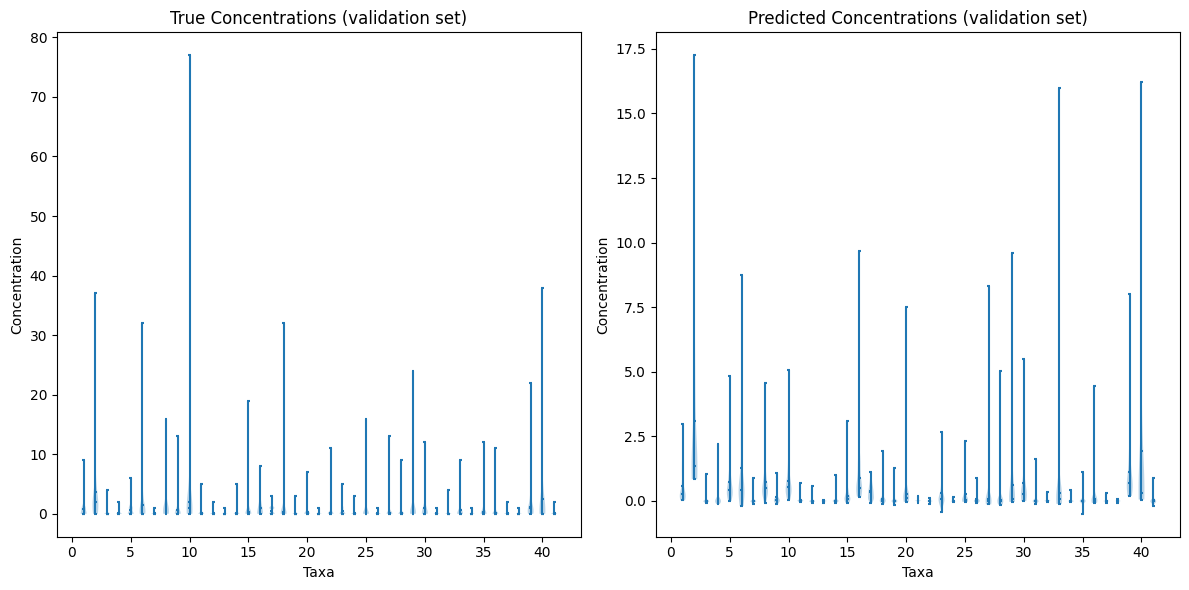

R² scores per taxon: [ 0.26413994  0.26196934  0.11447434  0.40304619  0.23290301  0.08558892
 -0.35318379 -0.00666673 -0.00680433  0.04873263  0.03402944 -0.06081108
 -0.066255   -0.10982578  0.25544124  0.35444257 -0.25173961 -0.00802552
 -0.07950442 -0.23487348 -0.06307109  0.00636825 -0.23314777 -0.05360008
  0.18079866  0.10915695  0.78186981  0.68000323  0.31881697  0.03243255
 -0.23168226  0.09638402 -0.47827569  0.10911974  0.04075088  0.56636881
 -0.0689541   0.00703034  0.34699336  0.41528661  0.06924245]
Mean R² score: 0.08558462183383268


In [ ]:
path = '~/whoi/ifcb/data/oleander/ifcb_clean_count_20250607.csv'
X, Y, taxa, scaler = load_data(path)

# 1. Split the data FIRST (no VAE yet!)
Z_dummy = np.zeros((len(Y), 1))  # dummy placeholder
splits = split_regression_data(X, Y, Z_dummy, test_size=0.2, val_size=0.1)

# 2. Train VAE on Y_train only
Y_train = splits['Y_train']
X_tensor = torch.tensor(Y_train.values, dtype=torch.float32)
dataset = TensorDataset(X_tensor)
dataloader = DataLoader(dataset, batch_size=2048, shuffle=True)

vae = VAE(input_dim=Y.shape[1], latent_dim=8)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
train_vae(vae, dataloader, optimizer, epochs=2000, device='mps' if torch.backends.mps.is_available() else 'cpu')

torch.save(vae.state_dict(), 'vae_model.pth')
print("VAE model saved.")

# 3. Encode all splits using trained VAE
Z_train = encode_latent_means(splits['Y_train'], vae)
Z_val   = encode_latent_means(splits['Y_val'], vae)
Z_test  = encode_latent_means(splits['Y_test'], vae)

# 4. Train RF using clean split
rf_model = train_regressor(splits['X_train'], Z_train)

torch.save(rf_model, 'rf_model.pth')
print("Random Forest model saved.")

# 5. Predict on validation set
Z_val_pred = rf_model.predict(splits['X_val'])
print("Predicted latent means shape:", Z_val_pred.shape)
# Decode the predictions back to concentrations
Y_val_pred = decode_and_inverse_transform(
    Z_val_pred, vae, scaler, taxa_columns=Y.columns.tolist(), device='mps' if torch.backends.mps.is_available() else 'cpu'
)
print("Predicted concentrations shape:", Y_val_pred.shape)
Y_val_true_scaled = splits['Y_val']
Y_val_true = np.sinh(scaler.inverse_transform(Y_val_true_scaled))
print("True concentrations shape:", Y_val_true.shape)
# make two side by side violin plots of the true and predicted concentrations
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.violinplot(Y_val_true, showmeans=True, showmedians=True)
plt.title('True Concentrations (validation set)')
plt.xlabel('Taxa')
plt.ylabel('Concentration')
plt.subplot(1, 2, 2)
plt.violinplot(Y_val_pred.values, showmeans=True, showmedians=True)
plt.title('Predicted Concentrations (validation set)')
plt.xlabel('Taxa')
plt.ylabel('Concentration')
plt.tight_layout()
plt.show()
# now compute R^2 scores per taxon
from sklearn.metrics import r2_score
r2_scores = r2_score(Y_val_true, Y_val_pred, multioutput='raw_values')
print("R² scores per taxon:", r2_scores)
print("Mean R² score:", r2_score(Y_val_true, Y_val_pred, multioutput='uniform_average'))

# Visualization

Environmental variables shape: (1469, 8)
Transformed + filtered taxa shape: (1469, 41)


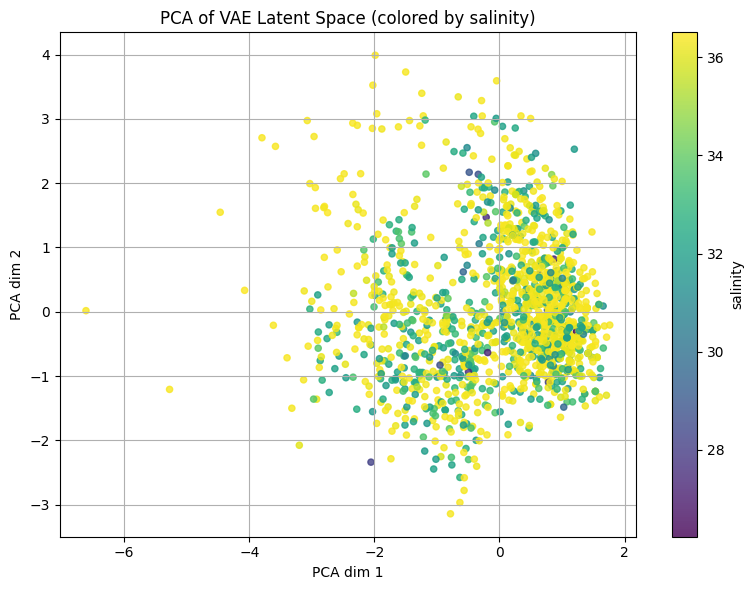

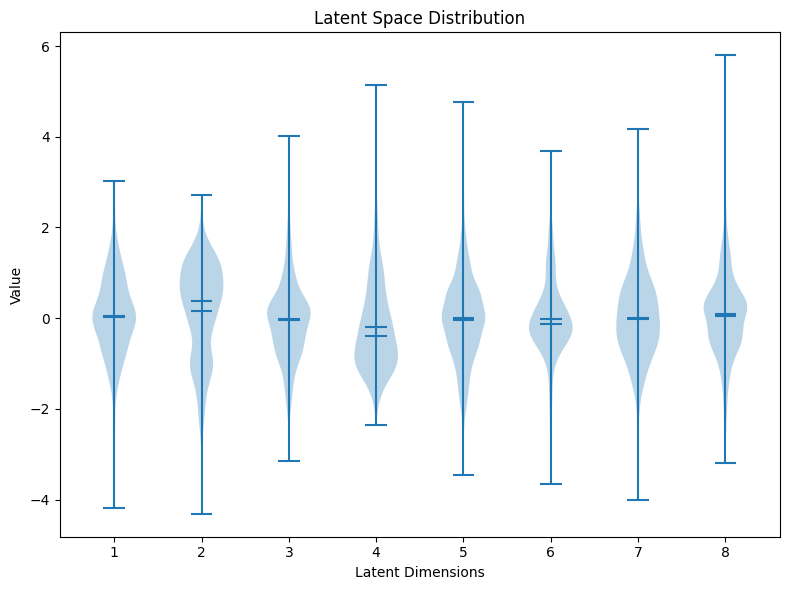

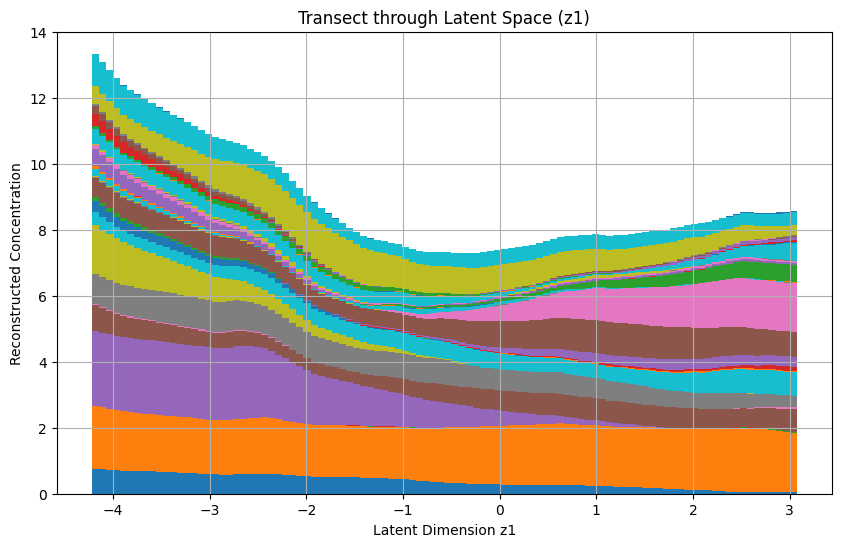

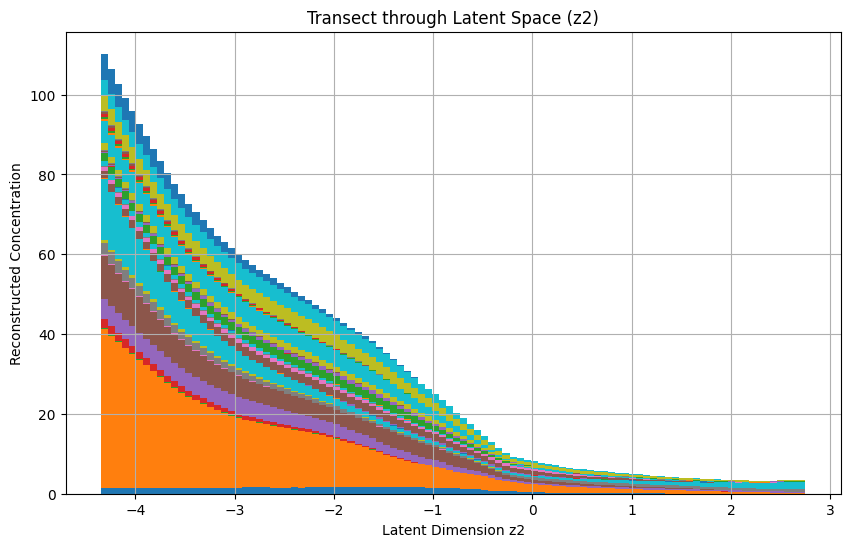

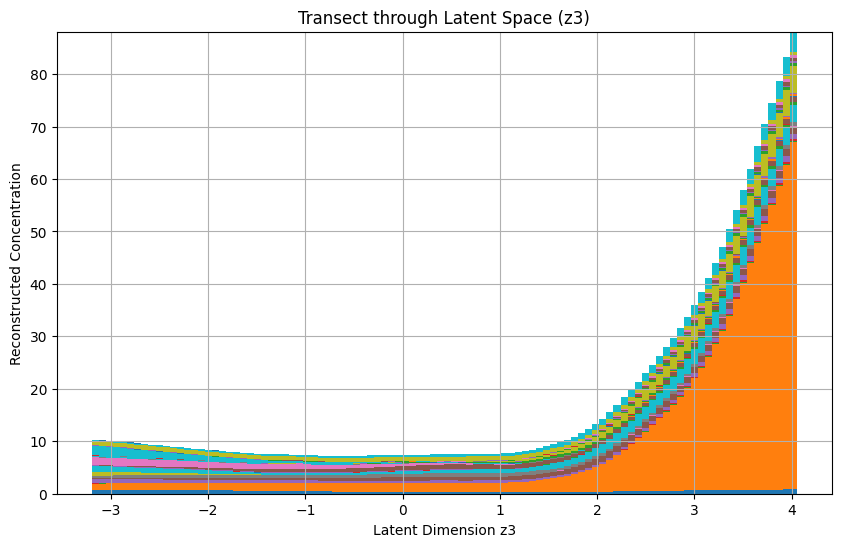

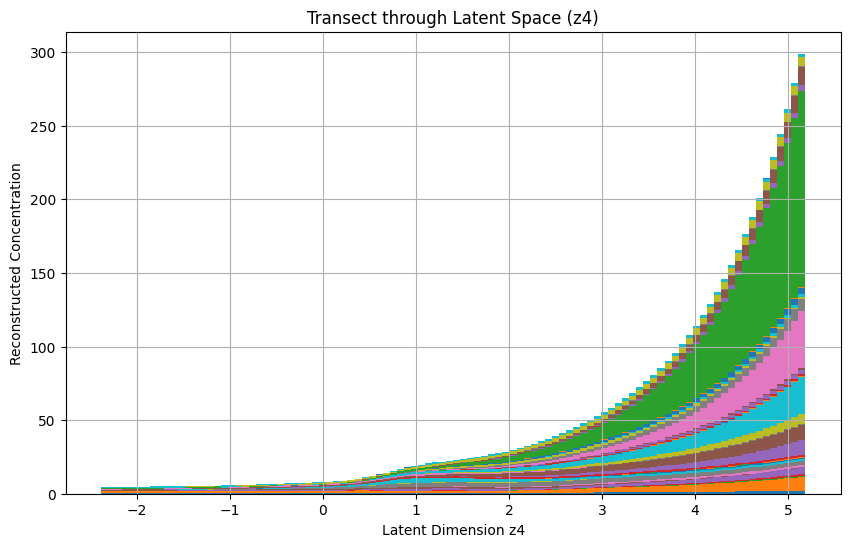

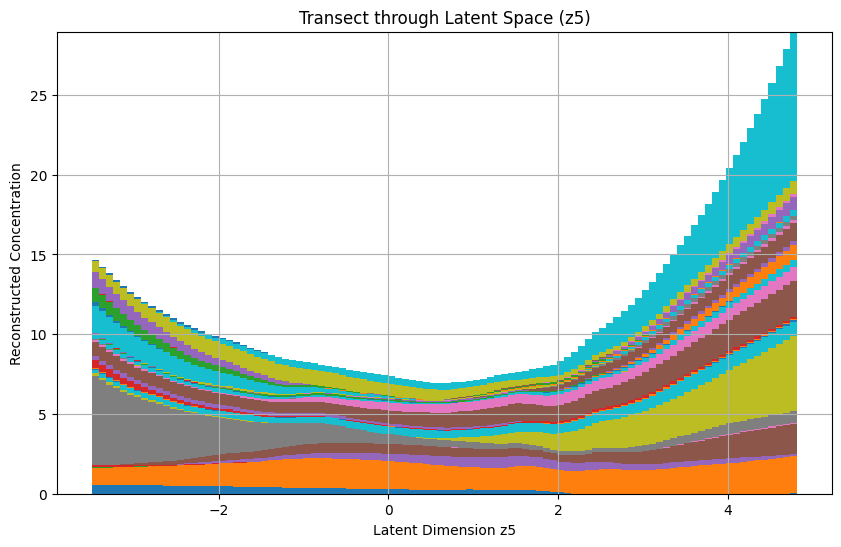

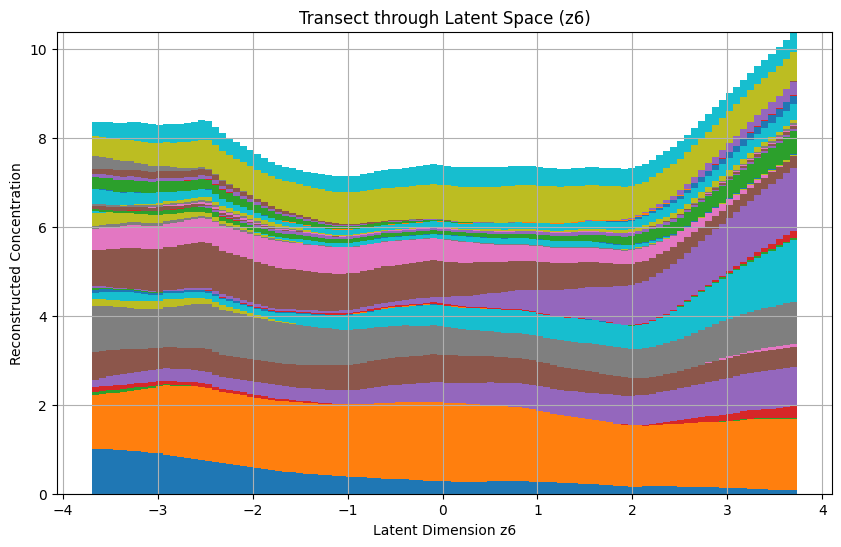

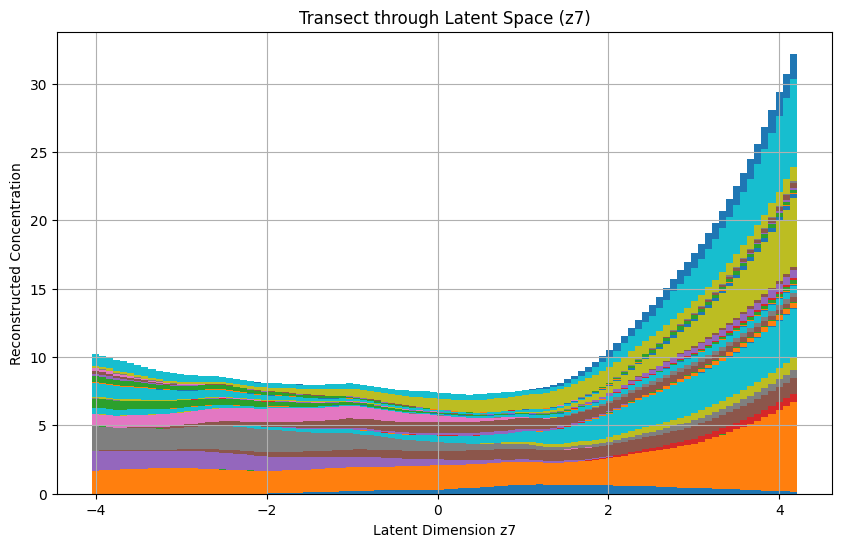

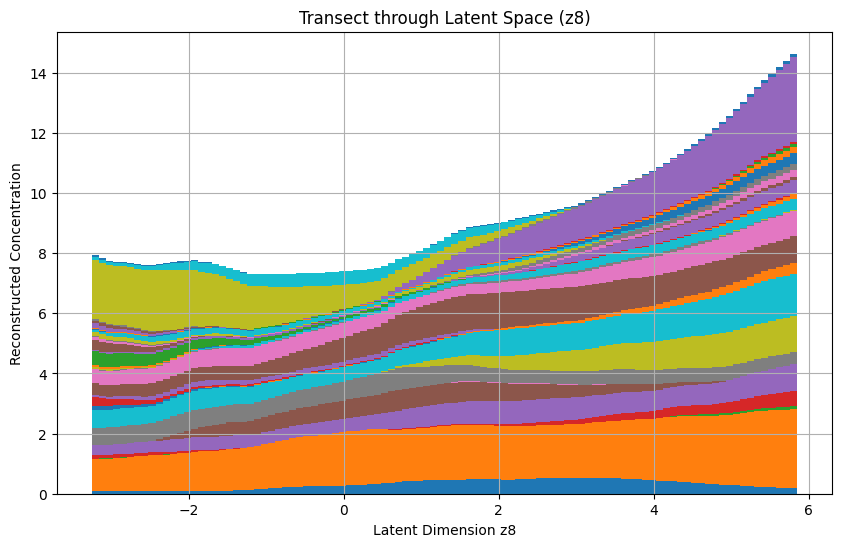

In [3]:
# Load data and preprocess
X_env, Y_scaled, taxa_columns, scaler = load_data(path)

# Visualize latent space
vae = VAE(input_dim=Y_scaled.shape[1], latent_dim=8)
vae.load_state_dict(torch.load('vae_model.pth'))
visualize_latent_space(vae, Y_scaled, X_env, color_var='salinity', scaler=scaler, method='pca', device='mps' if torch.backends.mps.is_available() else 'cpu')